In [1]:
# -*- coding: utf8

from scipy import stats as ss

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
import re

segments = []
points = []

lat_long_regex = r"<point lat=\"(.*)\" lng=\"(.*)\""

with open("states.txt", "r") as f:
    lines = [line for line in f]

for line in lines:
    if line.startswith("</state>"):
        for p1, p2 in zip(points, points[1:]):
            segments.append((p1, p2))
        points = []
    s = re.search(lat_long_regex, line)
    if s:
        lat, lon = s.groups()
        points.append((float(lon), float(lat)))

def plot_state_borders():
    for (lon1, lat1), (lon2, lat2) in segments:
        plt.plot([lon1, lon2], [lat1, lat2], lw=2, color='k')

# *k-Nearest Neighbors (kNN)*

Imagine que você está tentando prever como alguém irá votar na próxima eleição presidencial. Se você não sabe mais nada sobre a pessoa (e se você tem os dados), uma abordagem sensata é ver como os seus vizinhos estão planejando votar. Se, por exemplo, a pessoa vive no centro de Seattle, os seus vizinhos estão invariavelmente planejando votar no candidato democrata, o que sugere que "candidato democrata" é um bom palpite para ele também.

Agora imagine que você sabe mais sobre essa pessoa do que apenas geografia - talvez você saiba a sua idade, renda, quantos filhos tem, e assim por diante. Na medida em que o comportamento é influenciado (ou caracterizado) por essas coisas, olhando apenas para os seus vizinhos mais próximos considerando todas essas dimensões parece ser um indicador melhor do que olhar para todos os vizinhos. Essa é a ideia por trás da *classificação por vizinhos mais próximos*.

## O modelo

Os vizinhos mais próximos são um dos modelos preditivos mais simples que existem. Não faz suposições matemáticas e não requer nenhum tipo de maquinário pesado. As únicas coisas que requer são:

* Alguma noção de distância;
* Uma suposição de que pontos próximos um do outro são semelhantes;

A maioria das técnicas que usaremos neste curso analisa o conjunto de dados como um todo para aprender padrões nos dados. Os vizinhos mais próximos, por outro lado, negligenciam conscientemente muita informação, já que a previsão para cada novo ponto depende apenas dos poucos pontos mais próximos.

Além disso, os vizinhos mais próximos provavelmente não o ajudarão a entender o motivo por trás de qualquer fenômeno que você esteja observando. Prever os meus votos com base nos votos dos meus vizinhos não diz muito sobre o que me faz votar da forma que eu voto, enquanto que um modelo alternativo que previa o meu voto baseado (digamos) na minha renda e estado civil muito bem poderia.

Na situação geral, temos alguns pontos de dados e temos um conjunto de rótulos correspondente. Os rótulos podem ser `True` e `False`, indicando se cada entrada satisfaz alguma condição como "é spam?" Ou "é venenoso?" Ou "seria agradável assistir". Ou podem ser categorias, como a classificação indicativa de filmes (G, PG, PG-13, R, NC-17). Ou eles poderiam ser os nomes dos candidatos presidenciais. Ou poderiam ser linguagens de programação favoritas.

No nosso caso, os pontos de dados serão vetores, o que significa que podemos usar a função de distância que usamos anteriormente.

Digamos que escolhemos um número $k$ como 3 ou 5. Então, quando queremos classificar alguns novos pontos de dados, encontramos os k pontos marcados mais próximos e os deixamos votar no novo resultado.

Para fazer isso, precisamos de uma função que conte votos. Uma possibilidade é:

In [5]:
def raw_majority_vote(labels):
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

Mas isso não faz nada inteligente com empates. Por exemplo, imagine que estamos avaliando filmes e os cinco filmes mais próximos têm classificação G, G, PG, PG e R. Então, G tem dois votos e o PG também tem dois votos. Nesse caso, temos várias opções:

* Escolha um dos vencedores aleatoriamente.
* Ponderar os votos por distância e escolher o vencedor ponderado.
* Reduza k até encontrarmos um vencedor único.

Nós vamos implementar o terceiro:

In [6]:
from collections import Counter

def majority_vote(labels):
    """assumes that labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest


Essa abordagem certamente funcionará eventualmente, já que, no pior dos casos, vamos até um único rótulo, no ponto em que um rótulo ganha.

Com essa função, é fácil criar um classificador:

In [7]:
from scipy.spatial import distance

def knn_classify(k, labeled_points, new_point):
    """each labeled point should be a pair (point, label)"""

    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda point_label: distance.euclidean(point_label[0], new_point))

    # find the labels for the k closest
    k_nearest_labels = [label for _, label in by_distance[:k]]

    # and let them vote
    return majority_vote(k_nearest_labels)


Vamos ver agora como isso funciona.

## Exemplo: idiomas favoritos

No arquivo json prolanguages.json, temos dados sintéticos da linguagem de programação preferida de cientistas de dados. Os dados contêm para cada linguagem um local (latitude e logitude) onde aquela linguagem é preferida. Por exemplo, se cientistas de dados em NY preferem Python, teremos a localização no json.

In [8]:
import json
with open('proglanguages.json') as json_file:  
    data = json.load(json_file)
data[:5]
# Observe como é lat, lon e lang.

[[[-86.75, 33.5666666666667], 'Python'],
 [[-88.25, 30.6833333333333], 'Python'],
 [[-112.016666666667, 33.4333333333333], 'Java'],
 [[-110.933333333333, 32.1166666666667], 'Java'],
 [[-92.2333333333333, 34.7333333333333], 'R']]

O vice-presidente da *DataSciencester* quer saber se podemos usar esses resultados para prever as linguagens de programação favoritas para lugares que não faziam parte da nossa pesquisa.

Como de costume, um bom primeiro passo é plotar os dados:

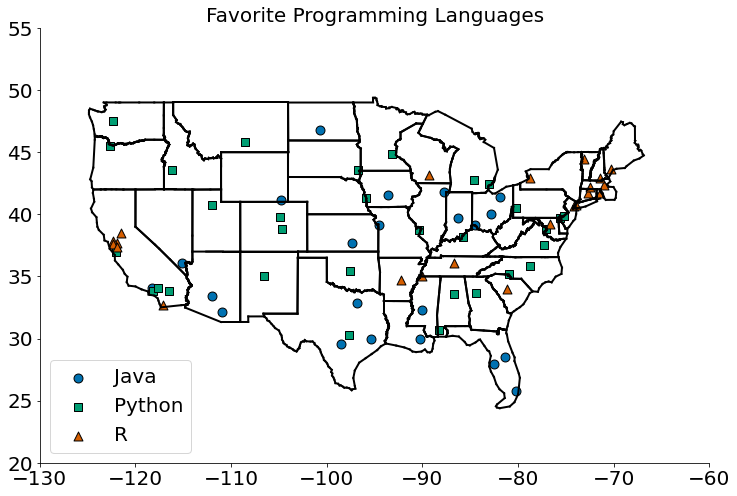

In [9]:
plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }
markers = { "Java" : "o", "Python" : "s", "R" : "^" }

for (longitude, latitude), language in data:
    plots[language][0].append(longitude)
    plots[language][1].append(latitude)

plot_state_borders()
for language, (x, y) in plots.items():
    plt.scatter(x, y, label=language, s=80, edgecolors='k',
                marker=markers[language])

plt.legend(loc=0)          # let matplotlib choose the location
plt.axis([-130,-60,20,55]) # set the axes
plt.title("Favorite Programming Languages")
despine()
plt.show()

Como parece que os lugares próximos tendem a gostar do mesmo idioma, os k vizinhos mais próximos parecem ser uma opção razoável para um modelo preditivo.

Para começar, vamos ver o que acontece se tentarmos prever o idioma preferido de cada cidade usando seus vizinhos (obviamente excluindo a própria da lista):

In [10]:
# try several different values for k
for k in [1, 3, 5, 7]:
    num_correct = 0
    
    for city in data:
        location, actual_language = city
        other_cities = [other_city
                        for other_city in data
                        if other_city != city]
        
        predicted_language = knn_classify(k, other_cities, location)
    
        if predicted_language == actual_language:
            num_correct += 1
    
    print(k, "neighbor[s]:", num_correct, "correct out of", len(data))

1 neighbor[s]: 40 correct out of 75
3 neighbor[s]: 44 correct out of 75
5 neighbor[s]: 41 correct out of 75
7 neighbor[s]: 35 correct out of 75


Parece que os 3 vizinhos mais próximos têm o melhor desempenho, dando o resultado correto em cerca de 59% das vezes.

Agora podemos ver quais regiões seriam classificadas em quais linguagens em cada esquema de vizinhos mais próximos. Podemos fazer isso classificando uma grade inteira de pontos e, em seguida, plotando-os como fizemos com cidades:

In [11]:
def classify_and_plot_grid(k=1):
    plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }
    markers = { "Java" : "o", "Python" : "s", "R" : "^" }
    colors  = { "Java" : "r", "Python" : "b", "R" : "g" }

    for longitude in range(-130, -60):
        for latitude in range(20, 55):
            predicted_language = knn_classify(k, data, [longitude, latitude])
            plots[predicted_language][0].append(longitude)
            plots[predicted_language][1].append(latitude)
    plot_state_borders()
    for language, (x, y) in plots.items():
        plt.scatter(x, y, label=language, s=80, edgecolors='k',
                    marker=markers[language], alpha=.6)

    plt.legend(loc=0)          # let matplotlib choose the location
    plt.axis([-130,-60,20,55]) # set the axes
    plt.title(str(k) + "-Nearest Neighbor Programming Languages")
    plt.show()

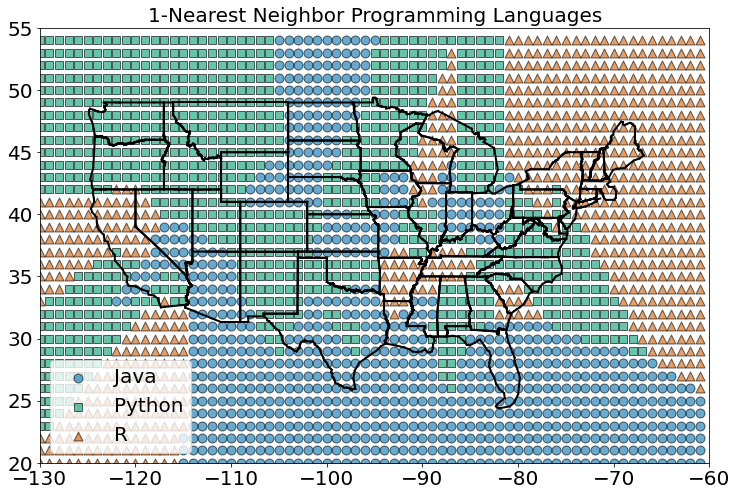

In [12]:
classify_and_plot_grid()

A figura acima mostra o que acontece quando olhamos apenas para o vizinho mais próximo (k = 1).

Vemos muitas mudanças abruptas de uma língua para outra com limites nítidos. À medida que aumentamos o número de vizinhos para três, vemos regiões mais suaves para cada idioma:

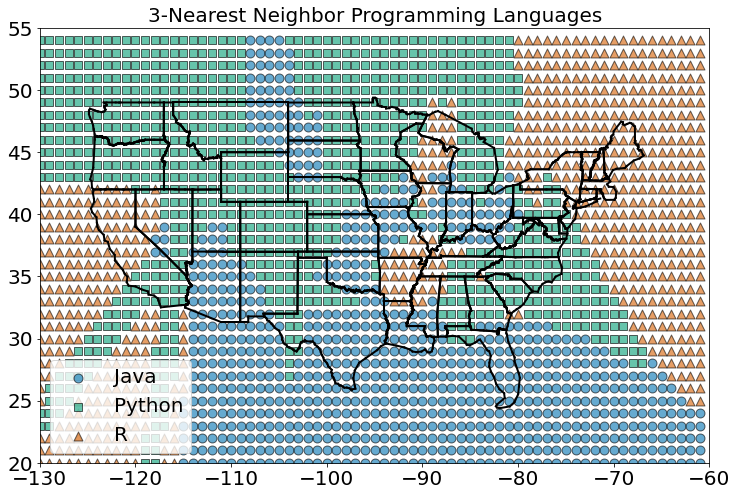

In [13]:
classify_and_plot_grid(3)

E à medida que aumentamos os vizinhos para cinco, os limites ficam mais estáveis ainda:

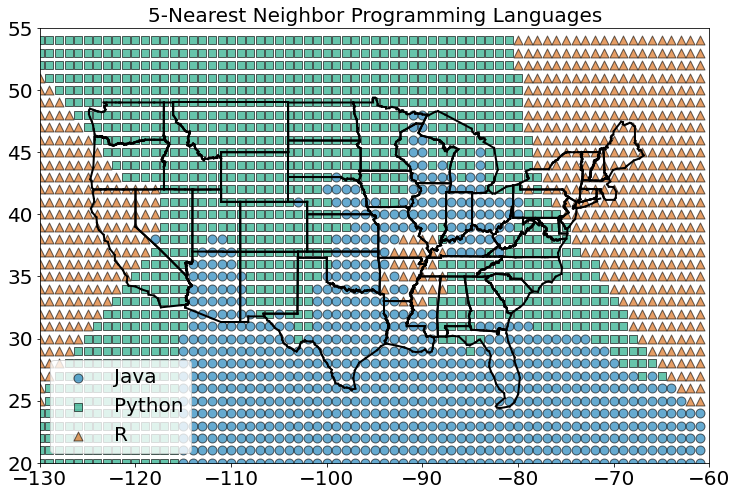

In [14]:
classify_and_plot_grid(5)

Aqui, nossas dimensões são aproximadamente comparáveis, mas se não fossem, você poderia redimensionar os dados como fizemos em uma aula anterior.

# A maldição da dimensionalidade

Os k vizinhos  mais próximos têm problemas em dimensões mais altas graças à "maldição da dimensionalidade", que se resume ao fato de que os espaços de alta dimensão são vastos. Pontos em espaços de alta dimensão tendem a não estar próximos uns dos outros. Uma maneira de ver isso é gerando aleatoriamente pares de pontos no "cubo unitário" d-dimensional em uma variedade de dimensões, e calculando as distâncias entre eles.

Gerar pontos aleatórios deve ser bem fácil agora:

In [15]:
def random_point(dim):
    return [np.random.rand() for _ in range(dim)]

A mesma coisa para escrever funções para gerar distâncias:

In [16]:
def random_distances(dim, num_pairs):
    return [distance.euclidean(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

Para cada dimensão de 1 a 100, calculamos 10.000 distâncias e as usamos para calcular a distância média entre os pontos e a distância mínima entre os pontos em cada dimensão:

In [17]:
dimensions = range(1, 101, 5)

avg_distances = []
min_distances = []

for dim in dimensions:
    distances = random_distances(dim, 10000)  # 10,000 random pairs
    avg_distances.append(np.mean(distances))     # track the average
    min_distances.append(min(distances))      # track the minimum
    print(dim, min(distances), np.mean(distances), min(distances) / np.mean(distances))

1 1.8313560171789867e-05 0.3301709583225029 5.54669019493278e-05
6 0.16769758556508108 0.9639033948122365 0.17397758579089528
11 0.47609082883079745 1.3317805085758905 0.3574844546567921
16 0.6907944566089326 1.6158037604013251 0.4275237337220682
21 0.8755821744563844 1.854279677002865 0.4721953140702149
26 1.1888263418314995 2.067303085437288 0.5750614654454657
31 1.3329114248563105 2.259892965206994 0.5898117501039359
36 1.5211200758656889 2.430760837880065 0.6257794070733427
41 1.7263801407492212 2.599443936164285 0.6641344007198137
46 1.7193997560511431 2.753811742519757 0.6243708418782035
51 1.784092033082398 2.910085514467705 0.6130720297436802
56 2.1715559084253138 3.049242055220478 0.7121625207508485
61 2.295348903321163 3.1750979196697116 0.7229222409493234
66 2.3253021305446473 3.309078507274127 0.7027038268911089
71 2.5301253427333146 3.4283364699179555 0.7380038000744611
76 2.609389777451642 3.5479697473137533 0.7354599850878856
81 2.700581604185344 3.6692393694134764 0.736

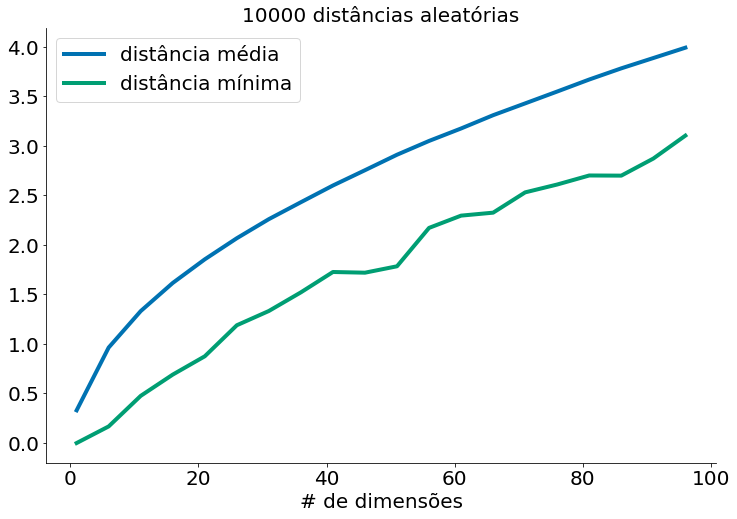

In [18]:
plt.plot(dimensions, avg_distances, label="distância média")
plt.plot(dimensions, min_distances, label="distância mínima")
plt.title("10000 distâncias aleatórias")
plt.xlabel("# de dimensões")
plt.legend()
despine()

À medida que o número de dimensões aumenta, a distância média entre os pontos aumenta. Mas o que é mais problemático é a relação entre a distância mais próxima e a distância média:

In [19]:
min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

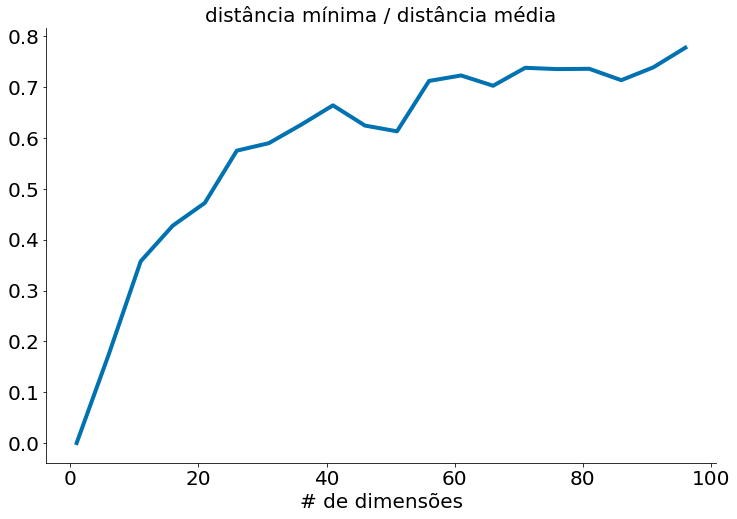

In [20]:
plt.plot(dimensions, min_avg_ratio)
plt.title("distância mínima / distância média")
plt.xlabel("# de dimensões")
despine()

Em conjuntos de dados de baixa dimensionalidade, os pontos mais próximos tendem a ser muito mais próximos que a média. Mas dois pontos estão próximos apenas se estiverem próximos em todas as dimensões, e cada dimensão extra - mesmo que seja apenas ruído - é outra oportunidade para cada ponto ficar mais distante de todos os outros pontos. Quando você tem muitas dimensões, é provável que os pontos mais próximos não estejam muito mais próximos do que a média, o que significa que dois pontos próximos não significam muito (a menos que haja muita estrutura em seus dados de modo que  eles se comportem como se fossem de uma dimensionalidade muito menor).

Imagine, por exemplo, se quisermos medir a distância entre as pessoas que habitam o planeta. Se olharmos para apenas algumas dimensões, como peso e altura, você verá pessoas muito próximas (mesma altura e mesmo peso) e pessoas muito distantes entre elas. Pense agora em adicionar outras dimensões, como idade, cor dos olhos, país de nascimento, cidade de nascimento, profissão, prato de comida favorito, filme favorito, esporte favorito, estilo musical favorito, estilo musical menos favorito etc. Agora pense em adicionar um conjunto ainda maior de dimensões. Você pode perceber que torna-se cada vez mais difícil encontrar pessoas que se parecem muito. Ao mesmo tempo, torna-se mais difícil encontrar pessoas que não têm nada em comum. Ou seja, todos tornam-se, na média, equidistantes entre si. 

Outra maneira de pensar sobre o problema envolve a esparsidade de espaços bidimensionais de alta ordem.

Se você escolher 50 números aleatórios entre 0 e 1, provavelmente obterá uma boa amostra do intervalo de uma unidade:

In [21]:
points = []
for i in range(50):
    points.append(random_point(1)[0])

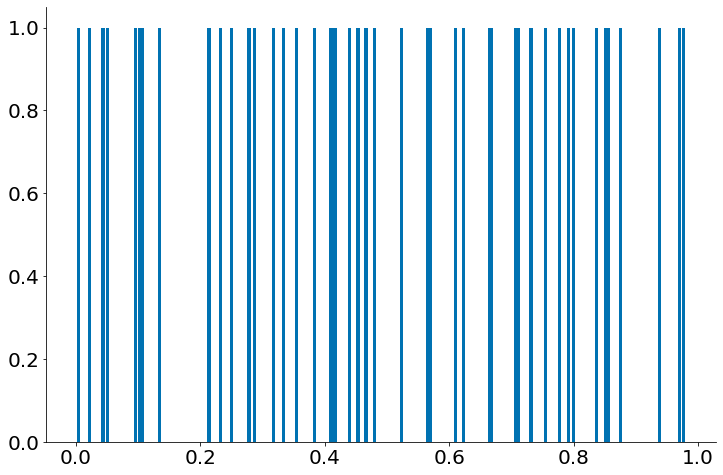

In [22]:
height = np.ones(50)
plt.bar(points, height, 0.005)
despine()

Se você sortear 50 pontos aleatórios em um quadrado de lado 1 (*unit square*), você obterá uma cobertura menor ainda:

In [23]:
points = []
for i in range(50):
    points.append(random_point(2))

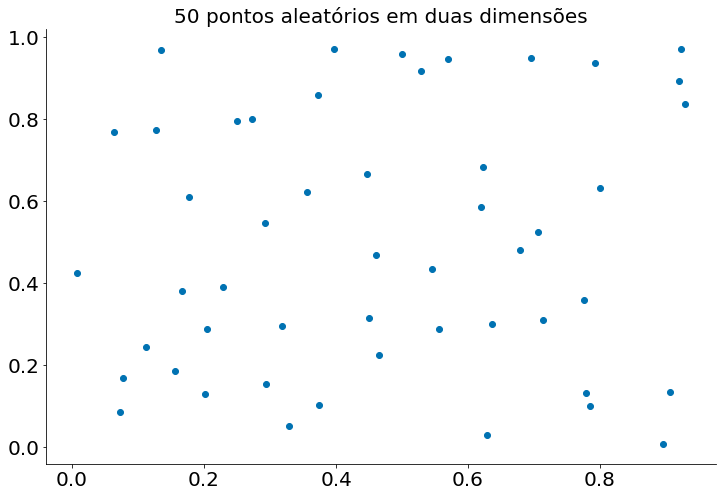

In [24]:
points = np.array(points)
plt.scatter(points[:,0], points[:,1])
plt.title("50 pontos aleatórios em duas dimensões")
despine()

E ainda mais em três dimensões:

In [25]:
points = []
for i in range(50):
    points.append(random_point(3))

Text(0.5, 0.92, '50 pontos aleatórios em três dimensões')

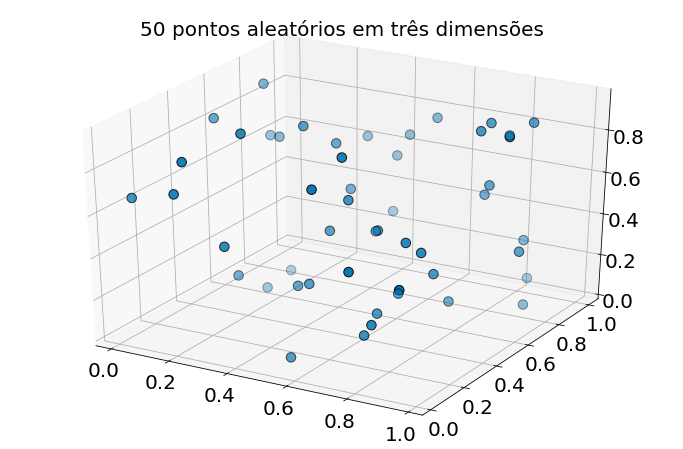

In [26]:
from mpl_toolkits.mplot3d import Axes3D
points = np.array(points)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=90, edgecolors='k')
plt.title("50 pontos aleatórios em três dimensões")

O `matplotlib` não representa graficamente quatro dimensões, de modo que, até onde formos, você já pode ver que estão começando a ficar grandes espaços vazios sem pontos próximos a eles. Em mais dimensões - a menos que você obtenha exponencialmente mais dados - esses grandes espaços vazios representam regiões muito distantes de todos os pontos que você deseja usar em suas previsões.

Então, se você está tentando usar os vizinhos mais próximos em dimensões mais altas, provavelmente é uma boa ideia fazer algum tipo de redução de dimensionalidade primeiro.

## Para explorar

* `scikit-learn` tem muitas modelos de [vizinhos mais próximos](http://scikit-learn.org/stable/modules/neighbors.html).